## Sensoriamento Remoto com GRASS-GIS

### 1 - Pré-processamento - correção atmosférica Landsat Collection 1 + 2

#### jupyter-notebook por Carlos H. Grohmann (Guâno)

In [1]:
# imports
import sys, os, itertools
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [2]:
# requires version 7.8+
# create GRASS GIS runtime environment

# definir o caminho do executável do GRASS, Aqui está para uma máquina Linux
# as duas formas abaixo retornam o mesmo resultado
gisbase = subprocess.check_output(["/usr/local/grass/bin/grass", "--config", "path"]).strip().decode() 
# gisbase = subprocess.check_output(["/usr/local/grass/bin/grass", "--config", "path"], text=True).strip() 

os.environ['GISBASE'] = gisbase
sys.path.append(os.path.join(gisbase, "etc", "python"))

# GRASS GIS imports
import grass.script as grass # este traz os módulos do GRASS
import grass.script.setup as gsetup
import grass.script.array as garray # este é para trabalhar com rasters como matrizes do numpy
# import grass.script.vector as gvect # este é para trablahar com vetores
import grass.jupyter as gj # este é para fazer o display dos mapas no notebook jupyter

# check GRASS version
print(gisbase)

/usr/local/grass/grass80


In [6]:
# set GRASS GIS session data

# aqui definimos o caminho da nossa Location/Mapset. Definir de acordo com o próprio sistema
rcfile = gsetup.init(gisbase, "/home/guano/HDD/grassdata/", "curso_yt_utm", "yt22")
# rcfile = gsetup.init(gisbase, "/mnt/d/grassdata/", "curso_yt_utm", "yt22")
# 
grass.message('Current GRASS GIS 7 environment:')
print (grass.gisenv())

{'GISDBASE': '/home/guano/HDD/grassdata/', 'LOCATION_NAME': 'curso_yt_utm', 'MAPSET': 'yt22'}


In [7]:
# define region - TODA A ÁREA DA CENA
n = 7390000
s = 7175000
w = 639000
e = 880000
res = 30
grass.run_command('g.region', flags='pa', s=s, n=n, w=w, e=e, res=res)

In [8]:
# ATENÇÃO - RODAR PARA TODA A CENA PODE SER DEMORADO.
# SE QUISER RODAR PARA UMA ÁREA MENOR, DEFINIR
# UMA REGION ***AGORA*** PARA DELIMITAR A ÁREA A SER IMPORTADA
# PELA REGION USANDO extent='region'

In [9]:
# check region
grass.parse_command('g.region', flags='pg')

{'projection': '1',
 'zone': '-22',
 'n': '7390020',
 's': '7174980',
 'w': '639000',
 'e': '880020',
 'nsres': '30',
 'ewres': '30',
 'rows': '7168',
 'cols': '8034',
 'cells': '57587712'}

In [12]:
# set data dir
# datadir = '/mnt/d/geodata/landsat/petar/'
datadir = '/home/guano/HDD/geodata/landsat/petar/'
    
l7c1_dir = 'LE07_L1TP_220077_19990926_20170217_01_T1'
l7c2_dir = 'LE07_L2SP_220077_19990926_20200918_02_T1'

l7c1_basefilename = 'LE07_L1TP_220077_19990926_20170217_01_T1_B'
l7c2_basefilename = 'LE07_L2SP_220077_19990926_20200918_02_T1_SR_B'

l7c1 = 'l7c1'
l7c2 = 'l7c2'



## Importar imagens Landsat Collection 1

In [30]:
# loop para importar as bandas. veja que esta abordagem não é perfeita, 
# porque se der problema em algum dos arquivos, é preciso rodar tudo de novo

# precisamos importar as bandas 6 porque o modulo i.landsat.toar precisa de todas

# L7, col1
for band in [1,2,3,4,5,'6_VCID_1','6_VCID_2',7,8]:
    tif = f'{datadir}{l7c1_dir}/{l7c1_basefilename}{band}.TIF'
    imp = f'{l7c1}_B.{band}'
    grass.run_command('r.import', input=tif, output=imp, extent='region', overwrite=True)

In [32]:
# vamos renomear as bandas 6 para acertar com o que o i.landsat.toar espera
grass.run_command('g.rename', raster=f'{l7c1}_B.6_VCID_1,{l7c1}_B.61')
grass.run_command('g.rename', raster=f'{l7c1}_B.6_VCID_2,{l7c1}_B.62')

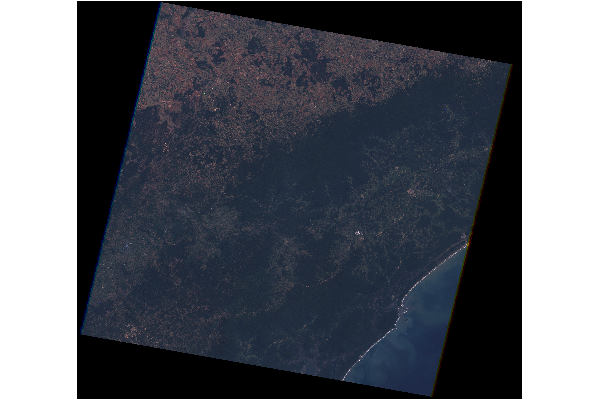

In [19]:
# mostrar mapas do grass no notebook usando a bibliotca grass.jupyter

#define o raster, para facilitar a vida depois 
r = f'{l7c1}_B.3' 
g = f'{l7c1}_B.2' 
b = f'{l7c1}_B.1' 

# Create GrassRenderer instance
img = gj.GrassRenderer()

# Adiciona raster, vector e legend ao mapa
# img.run('d.rast', map=rast) # raster simples, pode ter essa linha mais de uma vez
# img.d_vect(map="streams") # vetor simples
# img.run('d.legend',raster=rast, at=(55, 95, 80, 84), flags="b") #legenda de raster
img.run('d.rgb', red=r, green=g, blue=b)

# Display map
img.show()

In [23]:
# aumento de contraste do histograma
# o i.colors.enhance funciona com 3 bandas por vez

# atenção - o módulo só mexe nas cores, não nos dados

# define a imagem (nome base)
img = f'{l7c1}_B.'

(r,g,b) = (1,2,3)
grass.run_command('i.colors.enhance', red=f'{img}{r}', green=f'{img}{g}', blue=f'{img}{b}', strength=99)

(r,g,b) = (4,5,7)
grass.run_command('i.colors.enhance', red=f'{img}{r}', green=f'{img}{g}', blue=f'{img}{b}', strength=99)

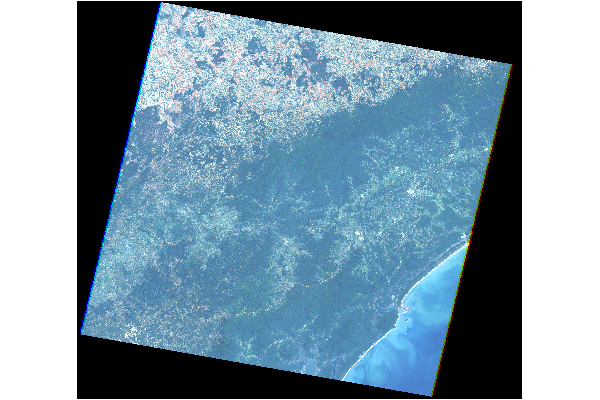

In [24]:
# mostrar mapas do grass no notebook usando a bibliotca grass.jupyter

r = f'{l7c1}_B.3' 
g = f'{l7c1}_B.2' 
b = f'{l7c1}_B.1' 

img = gj.GrassRenderer()
img.run('d.rgb', red=r, green=g, blue=b)
img.show()

## Importar imagens Landsat Collection 2

In [13]:
# L7, col2
# aqui vamos deixar a banda 6 de fora
for band in [1,2,3,4,5,7]:
    tif = f'{datadir}{l7c2_dir}/{l7c2_basefilename}{band}.TIF'
    imp = f'{l7c2}_B.{band}'
    grass.run_command('r.import', input=tif, output=imp, extent='region', overwrite=True)

## Scale factor + offset - collection 2 

https://www.usgs.gov/faqs/how-do-i-use-a-scale-factor-landsat-level-2-science-products?qt-news_science_products=0#qt-news_science_products

In [14]:
# scale factor and offset (VNIR, SWIR)
sfactor = 0.0000275
offset = -0.2

In [15]:
# L7, col2
for band in [1,2,3,4,5,7]:
    r_in = f'{l7c2}_B.{band}'
    r_out = f'{l7c2}_SR_B.{band}'
    grass.mapcalc(f'{r_out} = ({r_in}*{sfactor}) + {offset}', overwrite=True)
    grass.run_command('r.null', map=r_out, setnull='1.01-500')  
    grass.run_command('r.colors', map=r_out, color='grey')

### cores - histogram stretch collection 2

https://www.usgs.gov/faqs/what-are-band-designations-landsat-satellites?qt-news_science_products=0#qt-news_science_products

In [26]:
# L7, col2

img = f'{l7c2}_B.'

(r,g,b) = (1,2,3)
grass.run_command('i.colors.enhance', red=f'{img}{r}', green=f'{img}{g}', blue=f'{img}{b}', strength=99)

(r,g,b) = (4,5,7)
grass.run_command('i.colors.enhance', red=f'{img}{r}', green=f'{img}{g}', blue=f'{img}{b}', strength=99)

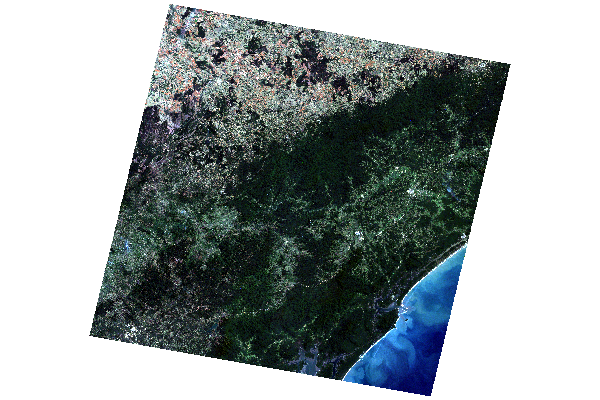

In [27]:
# mostrar mapas do grass no notebook usando a bibliotca grass.jupyter

r = f'{l7c2}_B.3' 
g = f'{l7c2}_B.2' 
b = f'{l7c2}_B.1' 

img = gj.GrassRenderer()
img.run('d.rgb', red=r, green=g, blue=b)
img.show()

## Rodar i.landsat.toar nas imagens Collection 1

### Reflectância de superfície, método DOS

In [19]:
# o i.landsat.toar pede como entrada o nome base das imagens, 
# e roda as correções para todas as bandas

dos = 'dos1'
r_in = f'{l7c1}_B.'
r_out = f'{l7c1}_SR_{dos}.'

met = f'{datadir}{l7c1_dir}/LE07_L1TP_220077_19990926_20170217_01_T1_MTL.txt'

grass.run_command('i.landsat.toar', input=r_in, output=r_out, metfile=met, 
                  sensor='tm7', method=dos, overwrite=True)

In [33]:
# e se quisermos fazer TODOS os métodos DOS?

met = f'{datadir}{l7c1_dir}/LE07_L1TP_220077_19990926_20170217_01_T1_MTL.txt'

for dos in ['dos1','dos2','dos2b','dos3','dos4']:
    r_in = f'{l7c1}_B.'
    r_out = f'{l7c1}_SR_{dos}.'
    grass.run_command('i.landsat.toar', input=r_in, output=r_out, metfile=met, 
                      sensor='tm7', method=dos, overwrite=True)

### cores - histogram stretch collection 1 DOS

In [35]:
# L7, col1, DOS1
img = f'{l7c1}_SR_dos1.'

(r,g,b) = (1,2,3)
grass.run_command('i.colors.enhance', red=f'{img}{r}', green=f'{img}{g}', blue=f'{img}{b}')

(r,g,b) = (4,5,7)
grass.run_command('i.colors.enhance', red=f'{img}{r}', green=f'{img}{g}', blue=f'{img}{b}')

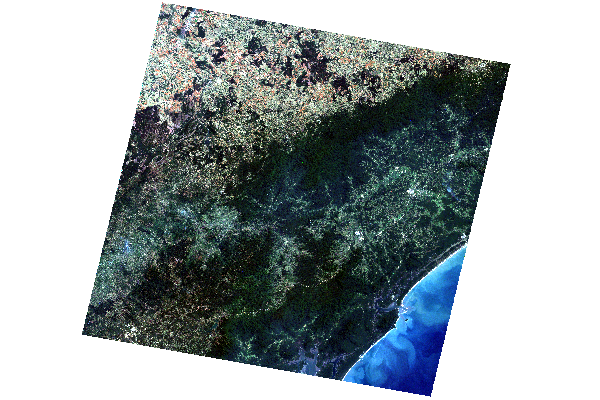

In [37]:
# mostrar mapas do grass no notebook usando a bibliotca grass.jupyter

r = f'{l7c1}_SR_dos1.3'
g = f'{l7c1}_SR_dos1.2'
b = f'{l7c1}_SR_dos1.1'

img = gj.GrassRenderer()
img.run('d.rgb', red=r, green=g, blue=b)
img.show()

## Rodar i.atcorr (6S) nas imagens Collection 1

https://grass.osgeo.org/grass78/manuals/i.atcorr.html  
https://grass.osgeo.org/grass78/manuals/i.landsat.toar.html

In [38]:
# Calcular reflectância TOA com i.landsat.toar

r_in = f'{l7c1}_B.'
r_out = f'{l7c1}_reflect_TOA_B.'

met = f'{datadir}{l7c1_dir}/LE07_L1TP_220077_19990926_20170217_01_T1_MTL.txt'

grass.run_command('i.landsat.toar', input=r_in, output=r_out, metfile=met, sensor='tm7', overwrite=True)

In [39]:
# Determinar horário de captura da imagem
# valor retirado do arquivo de matadados

# SCENE_CENTER_TIME = "13:03:55.4223650Z"
print(13 + 4/60)


13.066666666666666


In [40]:
# Determinar coordenadas do centro da imagem
# valores retirados do arquivo de matadados

CORNER_UL_LAT_PRODUCT = -23.59994
CORNER_UL_LON_PRODUCT = -49.63471
CORNER_UR_LAT_PRODUCT = -23.56157
CORNER_UR_LON_PRODUCT = -47.28801
CORNER_LL_LAT_PRODUCT = -25.53124
CORNER_LL_LON_PRODUCT = -49.61362
CORNER_LR_LAT_PRODUCT = -25.48931
CORNER_LR_LON_PRODUCT = -47.23082

center_longitude = (CORNER_LL_LON_PRODUCT + CORNER_UR_LON_PRODUCT) / 2
center_latitude  = (CORNER_UL_LAT_PRODUCT + CORNER_LR_LAT_PRODUCT) / 2

print(center_longitude)
print(center_latitude)

-48.450815
-24.544625


In [31]:
# arquivo de parâmetros

# 8                           # indicates that it is an ETM+ image
# 09 26 15.67 -24.544 -48.450 # image capture hour/day/lat/long
# 1                           # the tropical atmospheric model
# 1                           # the continental aerosol model
# 50                          # the visibility for the aerosol model [km]
# -0.58                       # the terrain lies 580 meters above sea level [km] * -1
# -1000                       # image taken of a satellite sensor (1000)
# 62                          # spectral band, here 1: blue


# https://grass.osgeo.org/grass78/manuals/i.atcorr.html
# 61	etm+ (landsat7) band 1 blue (435nm - 517nm)
# 62	etm+ (landsat7) band 2 green (508nm - 617nm)
# 63	etm+ (landsat7) band 3 red (625nm - 702nm)
# 64	etm+ (landsat7) band 4 NIR (753nm - 910nm)
# 65	etm+ (landsat7) band 5 SWIR (1520nm - 1785nm)
# 66	etm+ (landsat7) band 7 SWIR (2028nm - 2375nm)
# 67	etm+ (landsat7) band 8 PAN (505nm - 917nm)

In [47]:
# importar SRTM - coloquei aqui os arquivos no mesmo diretório das imagens para facilitar

tiles = ['S24W047','S24W048','S24W049','S24W050','S25W047','S25W048','S25W049','S25W050','S26W048','S26W049','S26W050']

for tile in tiles:
    hgt = f'{datadir}{tile}.hgt'
    grass.run_command('r.import', input=hgt, output=tile, overwrite=True)

In [48]:
# juntar tiles srtm em um só
grass.run_command('r.patch', input=tiles, output='srtm', overwrite=True)

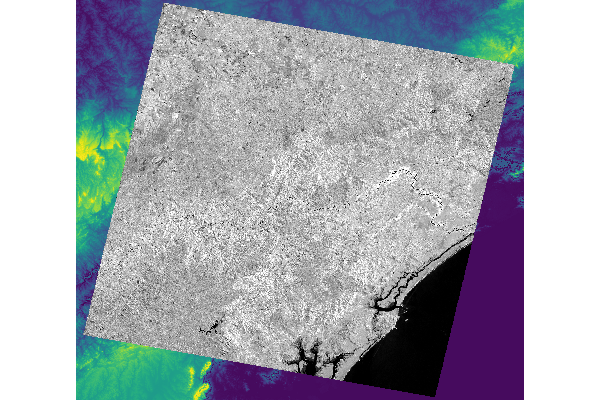

In [49]:
# mostrar mapas do grass no notebook usando a bibliotca grass.jupyter

rast = f'{l7c1}_SR_dos1.4'
dem = 'srtm'

img = gj.GrassRenderer()
img.run('d.rast', map=dem)
img.run('d.rast', map=rast)
img.show()

In [50]:
# correção 6S - usar flag 'r' para input de reflectância

for band in [1,2,3,4,5,7]:
    r_in = f'{l7c1}_reflect_TOA_B.{band}'
    r_out = f'{l7c1}_SR_6S_B.{band}'
    dem = 'srtm'
    param_txt = f'{datadir}iatcorr_l7_b{band}.txt'
    grass.run_command('i.atcorr', input=r_in, elevation=dem, parameters=param_txt, 
        output=r_out, flags='r', range=(0,1), rescale=(0,1), overwrite=True)

### cores - histogram stretch collection 1 6S

In [51]:
# L7, col1, 6S
img = f'{l7c1}_SR_6S_B.'

(r,g,b) = (1,2,3)
grass.run_command('i.colors.enhance', red=f'{img}{r}', green=f'{img}{g}', blue=f'{img}{b}')

(r,g,b) = (4,5,7)
grass.run_command('i.colors.enhance', red=f'{img}{r}', green=f'{img}{g}', blue=f'{img}{b}')

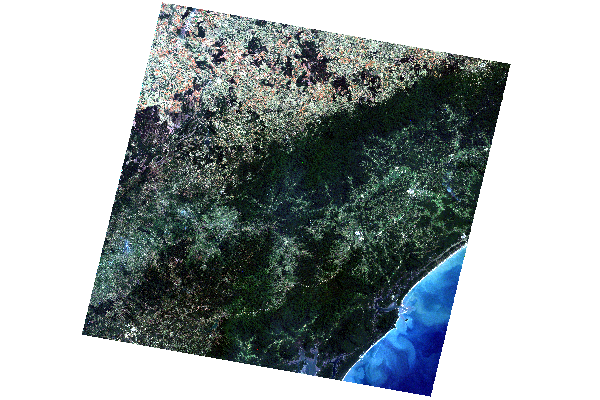

In [52]:
# mostrar mapas do grass no notebook usando a bibliotca grass.jupyter

r = f'{l7c1}_SR_6S_B.3'
g = f'{l7c1}_SR_6S_B.2'
b = f'{l7c1}_SR_6S_B.1'

img = gj.GrassRenderer()
img.run('d.rgb', red=r, green=g, blue=b)
img.show()

### Perfil espectral c/ pandas

In [91]:
# set region - floresta atlântica
n = 7288020
s = 7287030
w = 738000
e = 739140
res = 30
grass.run_command('g.region', flags='pa', s=s, n=n, w=w, e=e, res=res)

# listas para os valores dos rasters
list_toa = []
list_6s  = []
list_dos1 = []
list_dos2 = []
list_dos2b = []
list_dos3 = []
list_dos4 = []
list_c2  = []


for band in [1,2,3,4,5,7]:
    band_toa   = f'{l7c1}_reflect_TOA_B.{band}'
    band_6s    = f'{l7c1}_SR_6S_B.{band}'
    band_dos1  = f'{l7c1}_SR_dos1.{band}'
    band_dos2  = f'{l7c1}_SR_dos2.{band}'
    band_dos2b = f'{l7c1}_SR_dos2b.{band}'
    band_dos3  = f'{l7c1}_SR_dos3.{band}'
    band_dos4  = f'{l7c1}_SR_dos4.{band}'
    band_c2    = f'{l7c2}_SR_B.{band}'

    # for point-based analysis
#     coords = (181655,8262604)
#     value_toa   = float(grass.raster_what(band_toa, coord=coords)[0][band_toa]['value'])
#     value_6s    = float(grass.raster_what(band_6s, coord=coords)[0][band_6s]['value'])
#     value_dos1  = float(grass.raster_what(band_dos1, coord=coords)[0][band_dos1]['value'])
#     value_dos2  = float(grass.raster_what(band_dos2, coord=coords)[0][band_dos2]['value'])
#     value_dos2b = float(grass.raster_what(band_dos2b, coord=coords)[0][band_dos2b]['value'])
#     value_dos3  = float(grass.raster_what(band_dos3, coord=coords)[0][band_dos3]['value'])
#     value_dos4  = float(grass.raster_what(band_dos4, coord=coords)[0][band_dos4]['value'])
#     value_c2    = float(grass.raster_what(band_c2, coord=coords)[0][band_c2]['value'])

    # calculating mean value from small region
    value_toa   = float(grass.parse_command('r.univar', map=band_toa, flags='g')['mean'])
    value_6s    = float(grass.parse_command('r.univar', map=band_6s, flags='g')['mean'])
    value_dos1  = float(grass.parse_command('r.univar', map=band_dos1, flags='g')['mean'])
    value_dos2  = float(grass.parse_command('r.univar', map=band_dos2, flags='g')['mean'])
    value_dos2b = float(grass.parse_command('r.univar', map=band_dos2b, flags='g')['mean'])
    value_dos3  = float(grass.parse_command('r.univar', map=band_dos3, flags='g')['mean'])
    value_dos4  = float(grass.parse_command('r.univar', map=band_dos4, flags='g')['mean'])
    value_c2    = float(grass.parse_command('r.univar', map=band_c2, flags='g')['mean'])
    
    list_toa.append(value_toa)
    list_6s.append(value_6s)
    list_dos1.append(value_dos1)
    list_dos2.append(value_dos2)
    list_dos2b.append(value_dos2b)
    list_dos3.append(value_dos3)
    list_dos4.append(value_dos4)
    list_c2.append(value_c2)
    

# coloca os valores das listas no dataframe
spectral_profile = pd.DataFrame()
spectral_profile['C1_TOA'] = list_toa
spectral_profile['C1_6S'] = list_6s
spectral_profile['C1_DOS1'] = list_dos1
spectral_profile['C1_DOS2'] = list_dos2
spectral_profile['C1_DOS2b'] = list_dos2b
spectral_profile['C1_DOS3'] = list_dos3
spectral_profile['C1_DOS4'] = list_dos4
spectral_profile['C2_SR'] = list_c2


# center wavelenght of landsat 5 bands
def avg(a,b):
    return (a+b)/2

band_1 = avg(0.560,0.430)
band_2 = avg(0.650,0.500)
band_3 = avg(0.740,0.580)
band_4 = avg(0.950,0.730)
band_5 = avg(1.890,1.5025)
band_7 = avg(2.410,1.950)
centers = [band_1,band_2,band_3,band_4,band_5,band_7]

spectral_profile.index = centers


<AxesSubplot:>

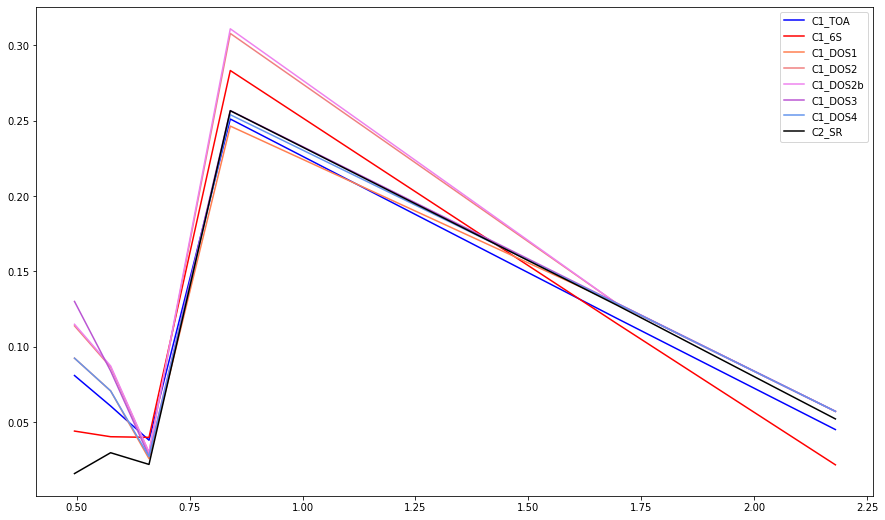

In [92]:
# set colors for plot

cols = ['C1_TOA', 'C1_6S', 'C1_DOS1', 'C1_DOS2', 'C1_DOS2b', 'C1_DOS3', 'C1_DOS4', 'C2_SR']
colors = ['blue', 'red', 'coral', 'lightcoral', 'violet', 'mediumorchid', 'cornflowerblue', 'black']

spectral_profile.plot(color=colors, figsize=(15,9))


### Índice de Vegetação

In [94]:
# define region - TODA A ÁREA DA CENA
n = 7390000
s = 7175000
w = 639000
e = 880000
res = 30
grass.run_command('g.region', flags='pa', s=s, n=n, w=w, e=e, res=res)

In [68]:
# qual índice de vegetação?
vi = 'ndvi'

In [69]:
# l7 c1, dos1
dos = 'dos1'
l = [f'{l7c1}_SR_{dos}.{band}' for band in [1,2,3,4,5,7]]

out_vi = f'{l7c1}_SR_{dos}_{vi}'

grass.run_command('i.vi', viname=vi, blue=l[0], green=l[1], red=l[2], nir=l[3], band5=l[4], band7=l[5],
              output=out_vi, overwrite = True)

# remove outliers
grass.run_command('r.null', map=out_vi, setnull='-1000--1.0,1.0-1000')  

# set ndvi colorscale
grass.run_command('r.colors', map=out_vi, color='ndvi')

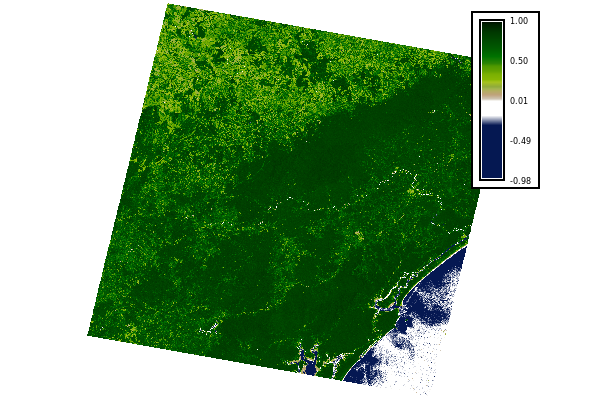

In [70]:
rast = f'{l7c1}_SR_{dos}_{vi}'
img = gj.GrassRenderer()
img.run('d.rast', map=rast)
img.run('d.legend',raster=rast, at=(55, 95, 80, 84), flags="b")
img.show()

In [95]:
# l7 c2
l = [f'{l7c2}_SR_B.{band}' for band in [1,2,3,4,5,7]]

out_vi = f'{l7c2}_SR_{vi}'

grass.run_command('i.vi', viname=vi, blue=l[0], green=l[1], red=l[2], nir=l[3], band5=l[4], band7=l[5],
              output=out_vi, overwrite = True)

# remove outliers
grass.run_command('r.null', map=out_vi, setnull='-1000--1.0,1.0-1000')  

# set ndvi colorscale
grass.run_command('r.colors', map=out_vi, color='ndvi')

### Correlação usando Numpy

In [96]:
import grass.script.array as garray

In [97]:
def raster_as_1d_array(raster):
    ''' return GRASS raster as numpy array - keep null values '''
    raster_array = garray.array()
    raster_array.read(raster, null=np.nan)
    return raster_array.flatten(order='C')

In [99]:
# define region para correlação
n = 7314510
s = 7270170
w = 711270
e = 753990
res = 30
grass.run_command('g.region', flags='pa', s=s, n=n, w=w, e=e, res=res)

In [131]:
band = 1

In [132]:
# collection 1 - dos1
c1 = f'l7c1_SR_dos1.{band}'
c1_array = raster_as_1d_array(c1)

In [133]:
c2 = f'l7c2_SR_B.{band}'
c2_array = raster_as_1d_array(c2)

In [134]:
s6 = f'l7c1_SR_6S_B.{band}'
s6_array = raster_as_1d_array(s6)

Text(0, 0.5, 'l7c1_SR_6S_B.1')

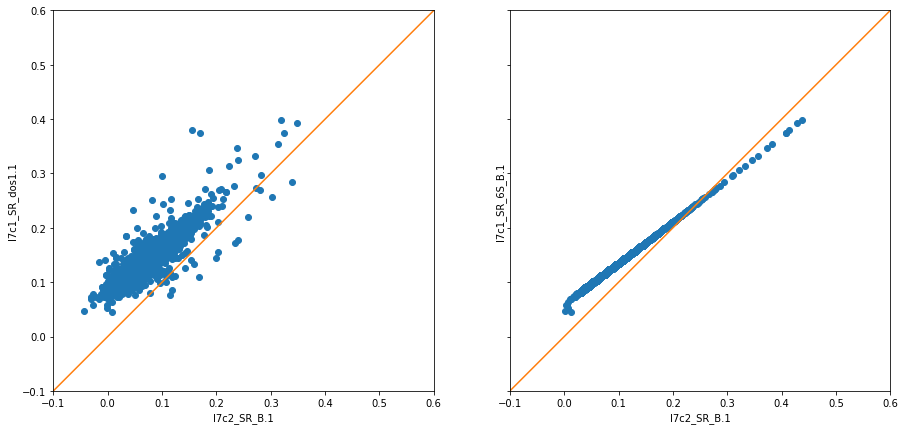

In [146]:
fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True,figsize=(15,7))

lims = (-0.1,0.6)

ax1.plot(c2_array,c1_array,'o')
ax1.plot([-1,1.1],[-1,1.1])
ax1.set_xlim(lims)
ax1.set_ylim(lims)
ax1.set_xlabel(c2)
ax1.set_ylabel(c1)

ax2.plot(s6_array,c1_array,'o')
ax2.plot([-1,1.1],[-1,1.1])
ax2.set_xlim(lims)
ax2.set_ylim(lims)
ax2.set_xlabel(c2)
ax2.set_ylabel(s6)


In [147]:
def plot_corr_c1_c2_6s(band):
    # collection 1 - dos1
    c1 = f'l7c1_SR_dos1.{band}'
    c1_array = raster_as_1d_array(c1)

    c2 = f'l7c2_SR_B.{band}'
    c2_array = raster_as_1d_array(c2)

    s6 = f'l7c1_SR_6S_B.{band}'
    s6_array = raster_as_1d_array(s6)

    fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True,figsize=(15,7))

    lims = (-0.1,0.6)

    ax1.plot(c2_array,c1_array,'o')
    ax1.plot([-1,1.1],[-1,1.1])
    ax1.set_xlim(lims)
    ax1.set_ylim(lims)
    ax1.set_xlabel(c2)
    ax1.set_ylabel(c1)

    ax2.plot(s6_array,c1_array,'o')
    ax2.plot([-1,1.1],[-1,1.1])
    ax2.set_xlim(lims)
    ax2.set_ylim(lims)
    ax2.set_xlabel(c2)
    ax2.set_ylabel(s6)

    plt.show()

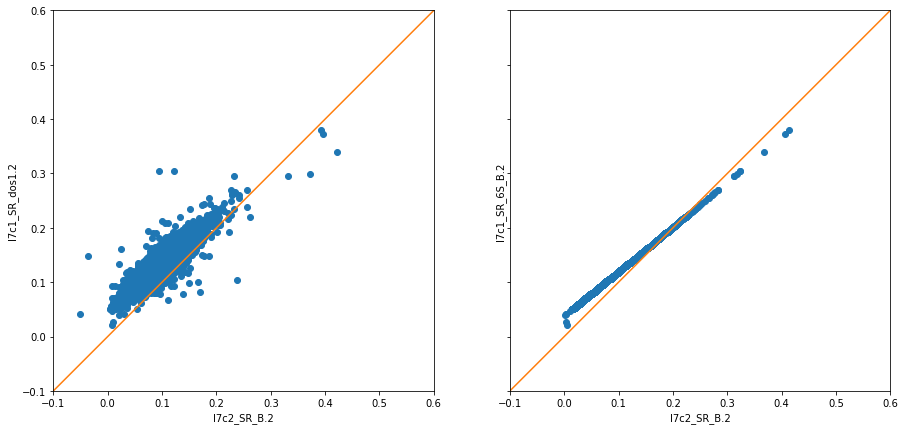

In [148]:
plot_corr_c1_c2_6s(2)